In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# activations
def relu(x):
    "zero if negative"
    return np.maximum(0, x)

def relu_grad(x):
    "derivative of relu function"
    return (x > 0).astype(float)

def sigmoid(x):
    "not being used right now"
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    "derivative of sigmoid function"
    return sigmoid(x) * (1 - sigmoid(x))

In [3]:
# encoding and decoding results
def onehot(y):
    "3 -> [0,0,0,1,0,0,0,0,0,0]"
    result = np.zeros((y.size, y.max() + 1))
    result[np.arange(y.size), y] = 1
    return result.T

def softmax(x):
    return np.exp(x) / sum(np.exp(x))

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [4]:
#import data
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#convert to np array
data = np.array(df)
m, n = data.shape #4200 rows, each is one image, first column in each row is label, rest is flattened image
np.random.shuffle(data)
m, n

(42000, 785)

In [6]:
#test train split
data_test = data[0:1000].T # (42000, 785) -> (785, 1000)
y_test = onehot(data_test[0]) # (1, 1000) -> (10, 1000)
x_test = data_test[1:n] # (785, 1000) -> (784, 1000)
x_test = x_test / 255. # scaling every pixel into (0, 1)

data_train = data[1000:m].T # (42000, 785) -> (785, 41000)
y_train = onehot(data_train[0]) # (1, 41000) -> (10, 41000)
x_train = data_train[1:n] # (785, 1000) -> (784, 1000)
x_train = x_train / 255.

In [7]:
class neural_network:
    def __init__(self, learning_rate, activation, deactivation):
        "initializing all weights and biases with small random floats in (-0.5, 0.5)"

        self.w1 = np.random.randn(10, 784) * 0.01
        self.b1 = np.zeros((10, 1))
        self.w2 = np.random.randn(10, 10) * 0.01
        self.b2 = np.zeros((10, 1))

        self.alpha = learning_rate
        self.activation = activation
        self.deactivation = deactivation

    def forwardprop(self, x):
        z1 = self.w1 @ x + self.b1 # (10, 784) @ (784, m) + (10, 1) = (10, m); bias is added to each column of resulting matrix
        a1 = self.activation(z1) # all negatives become 0
        z2 = self.w2 @ a1 + self.b2 # (10, 10) @ (10, m) + (10, 1) = (10, m)
        a2 = softmax(z2) # scales z2 into (0, 1)
        return z1, a1, a2
    
    def backprop(self, z1, a1, a2, x, y):
        inv_m = 1 / y.shape[1] # inverse of batch-size so we only need to do division once
        dz2 = a2 - y # (10, m) - (10, m) = (10, m); basicaly matrix with difference between each element
        dw2 = (dz2 @ a1.T) * inv_m # (10, m) @ (m, 10) = (10, 10); scaled down by batch size
        db2 = np.sum(dz2, axis=1, keepdims=True) * inv_m # sum of (10, m) matrix
        dz1 = (self.w2.T @ dz2) * self.deactivation(z1) # [(10, 10) @ (10, m)] @ (10, m) = (10, m) * (10, m)
        dw1 = dz1 @ x.T * inv_m # (10, m) @ (m, 784) = (10, 784)
        db1 = np.sum(dz1, axis=1, keepdims=True) * inv_m

        return dw1, db1, dw2, db2

    def update_model(self, dw1, db1, dw2, db2):
        "adjusts weights and biases, scaled down by learning rate"
        self.w1 -= dw1 * self.alpha
        self.b1 -= db1 * self.alpha
        self.w2 -= dw2 * self.alpha
        self.b2 -= db2 * self.alpha

    def train(self, x_train, y_train, iterations, reportingInterval):
        x_plot, y_plot = [], []
        for i in range(iterations):
            x = x_train
            y = y_train

            z1, a1, a2 = self.forwardprop(x)
            dw1, db1, dw2, db2 = self.backprop(z1, a1, a2, x, y)
            self.update_model(dw1, db1, dw2, db2)

            if i % reportingInterval == 0:
                print('run number ' + str(i))
                predictions = get_predictions(a2)
                key = get_predictions(y)
                accuracy = get_accuracy(predictions, key)
                print(accuracy)
                x_plot.append(i)
                y_plot.append(accuracy)

        plt.plot(x_plot, y_plot)

        return None

    def pred(self, x):
        _, _, a2  = self.forwardprop(x)
        return get_predictions(a2)
    
    def test_pred(self, index):
        prediction = self.pred(x_train[:, index, None])
        label = y_train[index]
        print("Prediction: ", prediction)
        print("Label: ", get_predictions(label))


run number 0
0.13753658536585367
run number 10
0.14902439024390243
run number 20
0.21565853658536585
run number 30
0.35873170731707316
run number 40
0.40090243902439027
run number 50
0.3577073170731707
run number 60
0.34246341463414637
run number 70
0.39463414634146343
run number 80
0.476
run number 90
0.5485121951219513
run number 100
0.6000731707317073
run number 110
0.6568048780487805
run number 120
0.7066097560975609
run number 130
0.7313170731707317
run number 140
0.7484146341463415
run number 150
0.7648780487804878
run number 160
0.7782682926829269
run number 170
0.7911951219512195
run number 180
0.8029024390243903
run number 190
0.8140731707317073
run number 200
0.8229512195121951
run number 210
0.830390243902439
run number 220
0.837
run number 230
0.8425609756097561
run number 240
0.848390243902439
run number 250
0.8529512195121951
run number 260
0.8574390243902439
run number 270
0.8609512195121951
run number 280
0.8636585365853658
run number 290
0.8668536585365854
run number 3

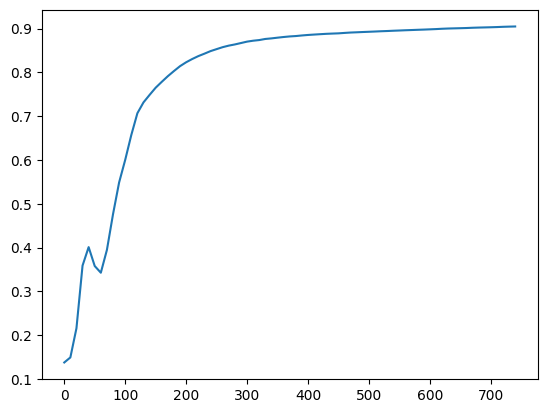

In [8]:
#training
model = neural_network(learning_rate=0.1,
                       activation=relu,
                       deactivation=relu_grad)

model.train(x_train=x_train, 
            y_train=y_train, 
            iterations=750, 
            reportingInterval=10)

In [9]:
#testing
predictions = model.pred(x_test)
get_accuracy(predictions, get_predictions(y_test)).item()

0.897

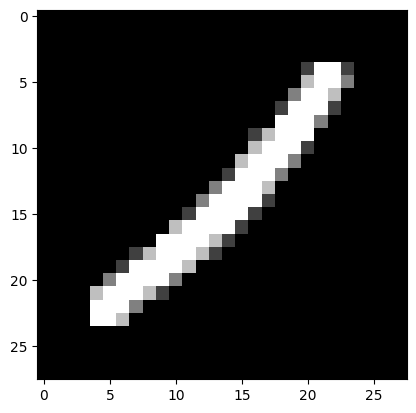

predicted: 1
actual: 1


In [10]:
#make predictions

x = x_test.T[11].reshape((784, 1))
y = y_test.T[11].reshape((10, 1))

current_image = x.reshape((28, 28)) * 255
plt.gray()
plt.imshow(current_image, interpolation='nearest')
plt.show()

print(f"predicted: {model.pred(x)[0]}")
print(f"actual: {get_predictions(y).item()}")